# Consumer Complaints Classification with LSTM

This script looks into the consumer complaints from Bank of America in California. It applies LSTM on complaint classification and figures out the products consumers are not satisfied with. 

In [1]:
import pandas as pd 

OUTPUT_FOLDER = os.getcwd() + '/output/'

data = pd.read_excel('consumer complaints BOA_CA.xlsx')
df = (pd.DataFrame(data, columns = ['product','consumer_complaint_narrative'])
        .dropna()
        .set_axis(['product', 'complaint'], axis = 1, inplace = False)
        .reset_index(drop = True))

## regroup product labels
df['product'] = df['product'].replace({
    'Consumer Loan': 'Consumer loan',
    'Payday loan': 'Consumer loan',
    'Student loan': 'Consumer loan',
    'Prepaid card': 'Bank account or service'
})

## create new features: message length
df['length'] = df['complaint'].apply(lambda x: len(x))

df.head()

,product,complaint,length
0,Mortgage,I Want to file a complaint about Bank of Ameri...,618
1,Mortgage,I got behind in payments and worked with B of ...,3833
2,Bank account or service,"This bank of america, gave all my money withou...",464
3,Bank account or service,I have made many mistakes when I was younger a...,3294
4,Bank account or service,I refinanced my home and chose to preserve my ...,513


## Text Pre-processing

- Remove stop words
- Tokenize, convert to lower case and remove punctuation
- Stem tokens using PorterStemmer


In [2]:
from gensim.utils import simple_preprocess
from gensim.parsing.porter import PorterStemmer
from gensim.parsing.preprocessing import remove_stopwords

porter_stemmer = PorterStemmer()

## function to clean raw text
def clean_txt(message):

    ### remove stop words
    message_no_stopwrd = remove_stopwords(message)

    ### simple preprocess
    tokens = simple_preprocess(message_no_stopwrd, deacc = True)

    ### stemming tokens
    tokens_stemmed = [porter_stemmer.stem(token) for token in tokens]

    return tokens_stemmed

## print raw text after cleaning 
df_token = df.assign(complaint = df['complaint'].apply(lambda x: clean_txt(x)))
df_token.head()

,product,complaint,length
0,Mortgage,"[want, file, complaint, bank, america, for, fo...",618
1,Mortgage,"[got, payment, work, loan, modif, dept, xxxx, ...",3833
2,Bank account or service,"[thi, bank, america, gave, monei, let, know, t...",464
3,Bank account or service,"[mistak, younger, xxxx, bank, america, last, y...",3294
4,Bank account or service,"[refinanc, home, chose, preserv, home, equiti,...",513


## Exploring Data

### (1) Inbalanced samples

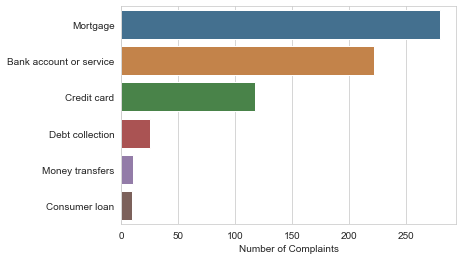

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
ax = sns.countplot(y = 'product', data = df_token, saturation = 0.5, order = df_token['product'].value_counts().index)
ax.set(xlabel = 'Number of Complaints', ylabel = '')
plt.show()

### (2) Complaint Length

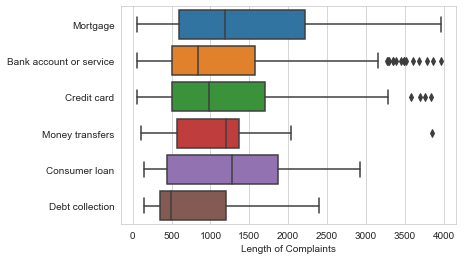

In [4]:
ax = sns.boxplot(x = 'length', y = 'product', data = df_token)
ax.set(xlabel = 'Length of Complaints', ylabel = '')
plt.show()

## Word Cloud

In [5]:
from wordcloud import WordCloud

## function to generate word cloud
def word_cloud_plotter(review_column):
  
    ### generate word cloud
    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color = 'white', 
                    min_font_size = 10).generate(str(review_column)) 
    
    ### plot word cloud
    plt.figure(figsize = (5, 5), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    
    plt.show() 

### (1) Mortgage

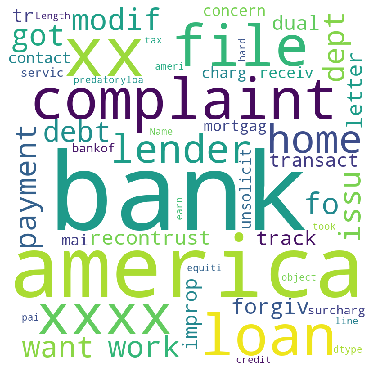

In [6]:
word_cloud_plotter(df_token.query('product == "Mortgage"').complaint)

### (2) Bank Account or Service

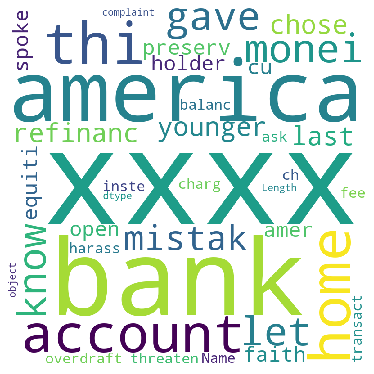

In [7]:
word_cloud_plotter(df_token.query('product == "Bank account or service"').complaint)

### (3) Credit Card

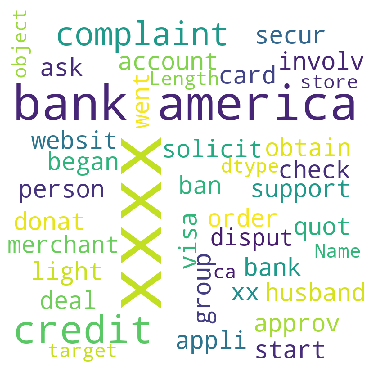

In [8]:
word_cloud_plotter(df_token.query('product == "Credit card"').complaint)

## Word Embeddings

In [9]:
from gensim.models import Word2Vec

## function to train models for work embeddings
def save_wEmbed(model_type, tokens):

    ### set up output folder
    word2vec_model_file = OUTPUT_FOLDER + 'word2vec_' + model_type + '.model'

    ### set up parameters
    size = 1000
    window = 3
    min_count = 1
    workers = 3
    sg = int(model_type == 'sGram')

    ### train model
    w2v_model = Word2Vec(tokens, 
                         min_count = min_count, 
                         size = size, 
                         workers = workers, 
                         window = window, 
                         sg = 1)
    ### save model 
    w2v_model.save(word2vec_model_file)

In [10]:
# extract tokens to fit 
stemmed_tokens = pd.Series(df_token['complaint']).values

# save CBOW
save_wEmbed('CBOW', stemmed_tokens)

# save skip-gram
save_wEmbed('sGram', stemmed_tokens)

## Vectorize Text

### TF-IDF

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(analyzer = 'word')
X = tfidf_vect.fit_transform(' '.join(token) for token in df_token['complaint'])

## extract TF-IDF matrix
X_tfidf = pd.DataFrame(X.toarray())
X_tfidf.columns = tfidf_vect.get_feature_names()
X_tfidf.head()

,aaa,aback,abandon,abbrevi,abey,abhorr,abid,abil,abl,ableto,...,younger,youngest,your,youth,yr,yyyi,zero,zevi,zip,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.033553,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.034633,0.0,...,0.073918,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### (2) word2vec CBOW & skip-gram

In [12]:
import numpy as np

## function to write vectorized reviews using work2vec model
def save_X_word2vec(model_type):

    ### set up output filename
    word2vec_filename = OUTPUT_FOLDER + 'X_word2vec_' + model_type + '.csv' 

    ### load word2vec model 
    w2v_model = Word2Vec.load(OUTPUT_FOLDER + 'word2vec_' + model_type + '.model')

    ### write csv file 
    with open(word2vec_filename, 'w+') as word2vec_file:
        for index, row in df_token.iterrows():
            model_vector = (np.mean([w2v_model[token] for token in row['complaint']], axis=0)).tolist()
            if index == 0:
                header = ",".join(str(ele) for ele in range(1000))
                word2vec_file.write(header)
                word2vec_file.write("\n")
            # Check if the line exists else it is vector of zeros
            if type(model_vector) is list:  
                line1 = ",".join( [str(vector_element) for vector_element in model_vector] )
            else:
                line1 = ",".join([str(0) for i in range(1000)])
            word2vec_file.write(line1)
            word2vec_file.write('\n')


# save_X_word2vec('CBOW')
# save_X_word2vec('sGram')

In [13]:
X_cbow = pd.read_csv(OUTPUT_FOLDER + 'X_word2vec_CBOW.csv')
X_sgram = pd.read_csv(OUTPUT_FOLDER + 'X_word2vec_sGram.csv')

## Modeling 



In [14]:
model_type = 'CBOW'

word_model = Word2Vec.load(OUTPUT_FOLDER + 'word2vec_' + model_type + '.model')
pretrained_weights = word_model.wv.syn0
vocab_size, emdedding_size = pretrained_weights.shape

In [15]:
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential # initial neural network
from keras.layers import Dense, LSTM, Embedding, SpatialDropout1D
from keras.callbacks import EarlyStopping

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=emdedding_size, weights=[pretrained_weights]))
model.add(LSTM(units=emdedding_size))
model.add(Dense(units=vocab_size, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

Using TensorFlow backend.


In [22]:
max_sentence_len = 300
train_x = np.zeros([df.shape[0], max_sentence_len], dtype=np.int32)
train_y = np.zeros([df.shape[0]], dtype=np.int32)
for i, sentence in enumerate(df['complaint']):
  for t, word in enumerate(df['complaint'][:-1]):
    train_x[i, t] = word_model.wv.vocab[word].index
  train_y[i] = word_model.wv.index2word[df['complaint'][-1]]

KeyError: "I Want to file a complaint about Bank of America For Foreclosing wrongly on me and my familys only home we had and loved! Bank of America ruined our life 's and we have been XXXX ever since they wrongly foreclosed on me during a loan modification I was almost done with and approved for! Its been almost 3 years since Bank of America took our home and all I received from the lawsuit was XXXX. Thats not even a mortgage payment! How is this fair or rite at all!? Bank of America should have to give us back our homes or help us get new ones since they were wrong and took everything from us we worked so hard to get! \n"

In [23]:
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

accr = model.evaluate(X_test, Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

NameError: name 'X_train' is not defined